# Simulasi - 4 Naive Bayes Multinomial + Natural Language Processing (Hatespeech Twitter Prediction)

## Penjelasan

### Tujuan

Memprediksi kategori "Hatespeech" dari tweet user twitter apakah termasuk "Netral" / "Rasis" / "Sara"

### Kolom

- User = User Twitter yang mengirim Tweet
- Tweet = Pesan yang disampaikan User
- Category = Kategori pesan/tweet

## A. Data Preparation

### A.1 Import Libraries

In [1111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

stemmer = StemmerFactory().create_stemmer()
stopword = StopWordRemoverFactory().create_stop_word_remover()

### A.2 Load Data

In [1112]:
try:
    df = pd.read_excel("TABEL DATA LATIH HATESPEECH RISET.xlsx", header=None)
    print("Berhasil Membaca Data")
except Exception as e:
    print("Gagal Membaca Data")

Berhasil Membaca Data


### 

In [1113]:
df.head()

,0,1,2
0,dxndelin,@amyliarm lingkunganmu keknya punya pemahaman ...,Netral
1,__succiduous,Udah jelek brengsek pula,Ras
2,KemenagMempawah,Lucunya penghuni negeri ini selalu di hiasi da...,Agama
3,1stKOREANguy1,"Yang jelek + miskin udah pasti bukan Kristen ,...",Ras
4,newsutdofficial,@MurtadhaOne1 Mereka memanfaatkan kebodohan ka...,Agama


In [1114]:
df.columns = ['User', 'Tweet', 'Category']

In [1115]:
df.duplicated().sum()

np.int64(45)

In [1116]:
df.drop_duplicates(inplace=True)

In [1117]:
df.isna().sum()

User        1
Tweet       1
Category    2
dtype: int64

In [1118]:
df.dropna(inplace=True)

In [1119]:
df.head()

,User,Tweet,Category
0,dxndelin,@amyliarm lingkunganmu keknya punya pemahaman ...,Netral
1,__succiduous,Udah jelek brengsek pula,Ras
2,KemenagMempawah,Lucunya penghuni negeri ini selalu di hiasi da...,Agama
3,1stKOREANguy1,"Yang jelek + miskin udah pasti bukan Kristen ,...",Ras
4,newsutdofficial,@MurtadhaOne1 Mereka memanfaatkan kebodohan ka...,Agama


#### Cleaning Text + Stemming Stopwords

In [1120]:
# def preprocess_text(text):
#     text = text.lower()
#     text = re.sub(r'[^a-z\s]', '', text)
    
#     return text

In [1121]:
# def text_preprocess(text):
    
#     text = text.lower()
#     text = re.sub(r'https?://\S+|www\.\S+', '', text)
#     text = re.sub(r'#\w+|@\w+|rt\s+|[^a-z\s]', ' ', text)
#     text = re.sub(r'\s+', ' ', text).strip()
    
#     text = stopword.remove(text)
#     text = stemmer.stem(text)
    
#     return text

#### Cleaning Text

In [1122]:
def preprocess_text(text_series):
    text = text_series.str.lower().str.replace(r'[^a-z\s]', ' ', regex=True).str.strip()
    return text

In [1123]:
# def text_preprocess(text):
#     text = text.lower()
#     text = re.sub(r'[^a-z\s]', '', text)
    
#     return text

In [1124]:
# df['Tweet_Clean'] = preprocess_text(df['Tweet'])
df['Tweet_Clean'] = preprocess_text(df['Tweet'])

In [1125]:
df['Tweet_Clean']

0       amyliarm lingkunganmu keknya punya pemahaman k...
1                                udah jelek brengsek pula
2       lucunya penghuni negeri ini selalu di hiasi da...
3       yang jelek   miskin udah pasti bukan kristen  ...
4       murtadhaone  mereka memanfaatkan kebodohan kad...
                              ...                        
1999                                  ikn potret kemajuan
2000    kurang ajar memang orang cina itu  sudah hidup...
2001    nah ini paham wahabi semakin merebak di sekita...
2002    kita hidup di negara pancasila  harus mengplem...
2003    dasar yahudi  musuh abadi umat islam  di dunia...
Name: Tweet_Clean, Length: 1957, dtype: object

In [1126]:
category_mapping = {'Netral' : 0, 'Ras' : 1, 'Agama' : 2}
df['Category'] = df['Category'].map(category_mapping)

## D. Modelling

### D.1 Defining X(Features) and y(Target) Variables

In [1127]:
X_data = df['Tweet_Clean']
y_data = df['Category']

### D.2 Splitting Train Data and Test Data (80:20)

In [1128]:
def stratified_split(X_data, y_data, train_size = 0.8, random_state=42):
    np.random.seed(random_state)
    
    x_train_list, x_test_list = [], []
    y_train_list, y_test_list = [], []
    
    for class_value in np.unique(y_data):
        class_idx = np.where(y_data == class_value)[0]
        
        idx = np.random.permutation(class_idx)
        split_ratio = int(len(idx) * train_size)
        
        x_train_list.append(X_data.iloc[idx[:split_ratio]])
        x_test_list.append(X_data.iloc[idx[split_ratio:]])
        y_train_list.append(y_data.iloc[idx[:split_ratio]])
        y_test_list.append(y_data.iloc[idx[split_ratio:]])
        
    x_train_ = pd.concat(x_train_list).reset_index(drop=True)
    x_test_ = pd.concat(x_test_list).reset_index(drop=True)
    y_train = pd.concat(y_train_list).reset_index(drop=True)
    y_test = pd.concat(y_test_list).reset_index(drop=True)
    
    return x_train_, x_test_, y_train, y_test
X_train , X_test, y_train, y_test = stratified_split(X_data, y_data)

### D.3 TF - IDF Formulas

#### Building Vocabulary

In [1129]:
def build_vocabulary(text_series, min_counts=3):
    counts = pd.Series(" ".join(text_series).split()).value_counts()
    valid_words = sorted(counts[counts >= min_counts].index)
    
    return {w: i for i, w in enumerate(valid_words)}

#### Calculating TF (Term Frequency)

In [1130]:
def calculate_tf(text_series, vocab_index):
    n_docs = len(text_series)
    n_vocab = len(vocab_index)
    tf_matrix = np.zeros((n_docs, n_vocab))
    
    for row, text in enumerate(text_series):
        words = text.split()
        for w in words:
            if w in vocab_index:
                col_idx = vocab_index[w]
                tf_matrix[row, col_idx] += 1
                
    return tf_matrix

#### Calculating IDF (Inverse Document Frequency)

In [1131]:
def calculate_idf(text_series, vocab_index):
    n_docs = len(text_series)
    df_counts = dict.fromkeys(vocab_index.keys(), 0)
    
    for text in text_series:
        for word in set(text.split()):
            if word in df_counts:
                df_counts[word] += 1
        
    return {word: np.log(n_docs / (count + 1)) for word, count in df_counts.items()}

#### Calculating TF - IDF

In [1132]:
def multiply_tf_idf(tf_matrix, vocab_index, idf_values):
    matrix = tf_matrix.copy()
    
    for w, idx_col in vocab_index.items():
        matrix[:, idx_col] *= idf_values[w]
    
    return matrix

#### Normalize Documents

In [1133]:
def normalize_l2(matrix):
    norms = np.sqrt(np.sum(matrix ** 2, axis=1, keepdims=True))
    norms[norms == 0] = 1
    return matrix / norms

#### Run All TF-IDF Functions

In [1134]:
vocab_index = build_vocabulary(X_train)

tf_train = calculate_tf(X_train, vocab_index)
tf_test = calculate_tf(X_test, vocab_index)

idf_values = calculate_idf(X_train, vocab_index)

X_train_matrix = multiply_tf_idf(tf_train, vocab_index, idf_values)
X_test_matrix = multiply_tf_idf(tf_test, vocab_index, idf_values)

X_train_matrix = normalize_l2(X_train_matrix)
X_test_matrix = normalize_l2(X_test_matrix)

print(f"Dimensi Train: {X_train_matrix.shape}")
print(f"Dimensi Test: {X_test_matrix.shape}")

Dimensi Train: (1564, 1389)
Dimensi Test: (393, 1389)


### D.4 Naive Bayes Multinomial

In [1135]:
class NaiveBayesMultinomial:
    def __init__(self, alpha=1):
        self.alpha = alpha
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)
        
        self._priors = np.zeros(n_classes)
        self._feature_probs = np.zeros((n_classes, n_features))
        
        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._priors[idx] = X_c.shape[0] / n_samples
            
            numerator = X_c.sum(axis=0) + self.alpha
            denominator = X_c.sum() + (self.alpha * n_features)
            
            self._feature_probs[idx] = numerator / denominator
            
    def _predict(self, x):
        posteriors = []
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            likelihood = np.sum(x * np.log(self._feature_probs[idx]))
            posterior = prior + likelihood
            posteriors.append(posterior)
        return self._classes[np.argmax(posteriors)]
    
    def predict(self, X):
        return np.array([self._predict(x) for x in X])

### D.5 Grid Search (Finding Best Alpha)

In [ ]:
print("| Accuracy | Alpha | Min Counts |")

best_acc = 0
best_alpha = 0
best_mincounts = 0
list_alpha = [0.1, 0.2, 0.3, 0.4, 0w.5, 1, 2, 3, 4, 5]
list_mincounts = [1, 2, 3, 4]

for mc in list_mincounts:
    vocab_cek = build_vocabulary(X_train, mc)
    
    tf_train_cek = calculate_tf(X_train, vocab_cek)
    tf_test_cek = calculate_tf(X_test, vocab_cek)
    idf_values_cek = calculate_idf(X_train, vocab_cek)
    
    X_train_matrix_cek = multiply_tf_idf(tf_train_cek, vocab_cek, idf_values_cek)
    X_test_matrix_cek = multiply_tf_idf(tf_test_cek, vocab_cek, idf_values_cek)
    
    X_train_matrix_cek = normalize_l2(X_train_matrix_cek)
    X_test_matrix_cek = normalize_l2(X_test_matrix_cek)
    
    for a in list_alpha:
        nbm = NaiveBayesMultinomial(a)
        nbm.fit(X_train_matrix_cek, y_train)
        pred = nbm.predict(X_test_matrix_cek)
        acc = np.mean(pred == y_test)
        print(f"|  {acc:.4f}  |  {a}  |  {mc}  |")
        
        if acc > best_acc:
            best_acc = acc
            best_alpha = a
            best_mincounts = mc
        
print(f"| Best Accuracy: {best_acc}  | Best Alpha: {best_alpha}  | Best Min Counts: {best_mincounts}")

| Accuracy | Alpha | Min Counts |
|  0.6234  |  0.1  |  1  |
|  0.6285  |  0.2  |  1  |
|  0.6310  |  0.3  |  1  |
|  0.6412  |  0.4  |  1  |
|  0.6539  |  0.5  |  1  |
|  0.6387  |  1  |  1  |
|  0.6081  |  2  |  1  |
|  0.5496  |  3  |  1  |
|  0.5165  |  4  |  1  |
|  0.4936  |  5  |  1  |
|  0.6234  |  0.1  |  2  |
|  0.6412  |  0.2  |  2  |
|  0.6361  |  0.3  |  2  |
|  0.6285  |  0.4  |  2  |
|  0.6361  |  0.5  |  2  |
|  0.6438  |  1  |  2  |
|  0.6514  |  2  |  2  |
|  0.6285  |  3  |  2  |
|  0.5802  |  4  |  2  |
|  0.5573  |  5  |  2  |
|  0.6463  |  0.1  |  3  |
|  0.6412  |  0.2  |  3  |
|  0.6412  |  0.3  |  3  |
|  0.6412  |  0.4  |  3  |
|  0.6489  |  0.5  |  3  |
|  0.6641  |  1  |  3  |
|  0.6590  |  2  |  3  |
|  0.6438  |  3  |  3  |
|  0.6387  |  4  |  3  |
|  0.5980  |  5  |  3  |
|  0.6158  |  0.1  |  4  |
|  0.6234  |  0.2  |  4  |
|  0.6310  |  0.3  |  4  |
|  0.6310  |  0.4  |  4  |
|  0.6310  |  0.5  |  4  |
|  0.6539  |  1  |  4  |
|  0.6463  |  2  |  4  |
|

In [1137]:
print("| Accuracy | Alpha | Min Counts |")

best_acc = 0
best_alpha = 0
best_mincounts = 0
list_alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 3, 4, 5]
list_mincounts = [1, 2, 3, 4]

for mc in list_mincounts:
    vocab_cek = build_vocabulary(X_train, mc)
    
    tf_train_cek = calculate_tf(X_train, vocab_cek)
    tf_test_cek = calculate_tf(X_test, vocab_cek)
    idf_values_cek = calculate_idf(X_train, vocab_cek)
    
    X_train_matrix_cek = multiply_tf_idf(tf_train_cek, vocab_cek, idf_values_cek)
    X_test_matrix_cek = multiply_tf_idf(tf_test_cek, vocab_cek, idf_values_cek)
    
    X_train_matrix_cek = normalize_l2(X_train_matrix_cek)
    X_test_matrix_cek = normalize_l2(X_test_matrix_cek)
    
    for a in list_alpha:
        nbm = NaiveBayesMultinomial(a)
        nbm.fit(X_train_matrix_cek, y_train)
        pred = nbm.predict(X_train_matrix_cek)
        acc = np.mean(pred == y_train)
        print(f"|  {acc:.4f}  |  {a}  |  {mc}  |")
        
        if acc > best_acc:
            best_acc = acc
            best_alpha = a
            best_mincounts = mc
        
print(f"| Best Accuracy: {best_acc}  | Best Alpha: {best_alpha}  | Best Min Counts: {best_mincounts}")

| Accuracy | Alpha | Min Counts |
|  0.9840  |  0.1  |  1  |
|  0.9808  |  0.2  |  1  |
|  0.9789  |  0.3  |  1  |
|  0.9776  |  0.4  |  1  |
|  0.9744  |  0.5  |  1  |
|  0.9437  |  1  |  1  |
|  0.8408  |  2  |  1  |
|  0.7283  |  3  |  1  |
|  0.6234  |  4  |  1  |
|  0.5588  |  5  |  1  |
|  0.9380  |  0.1  |  2  |
|  0.9322  |  0.2  |  2  |
|  0.9297  |  0.3  |  2  |
|  0.9258  |  0.4  |  2  |
|  0.9201  |  0.5  |  2  |
|  0.8945  |  1  |  2  |
|  0.8350  |  2  |  2  |
|  0.7666  |  3  |  2  |
|  0.6976  |  4  |  2  |
|  0.6445  |  5  |  2  |
|  0.8875  |  0.1  |  3  |
|  0.8843  |  0.2  |  3  |
|  0.8824  |  0.3  |  3  |
|  0.8747  |  0.4  |  3  |
|  0.8721  |  0.5  |  3  |
|  0.8676  |  1  |  3  |
|  0.8223  |  2  |  3  |
|  0.7775  |  3  |  3  |
|  0.7276  |  4  |  3  |
|  0.6835  |  5  |  3  |
|  0.8568  |  0.1  |  4  |
|  0.8536  |  0.2  |  4  |
|  0.8510  |  0.3  |  4  |
|  0.8472  |  0.4  |  4  |
|  0.8472  |  0.5  |  4  |
|  0.8357  |  1  |  4  |
|  0.8037  |  2  |  4  |
|

### D.6 Predict With Best Alpha

In [1138]:
nbm = NaiveBayesMultinomial(1)
nbm.fit(X_train_matrix, y_train)

y_pred_test = nbm.predict(X_test_matrix)
y_pred_train = nbm.predict(X_train_matrix)

## E. Evaluasi

### E.1 Accuracy

#### Test Accuracy

In [1139]:
test_accuracy = np.mean(y_pred_test == y_test)
print(f"{test_accuracy:.3f}")

0.664


#### Train Accuracy

In [1140]:
train_accuracy = np.mean(y_pred_train == y_train)
print(f"{train_accuracy:.3f}")

0.868


### E.2 Confusion Matrix Multi-Class

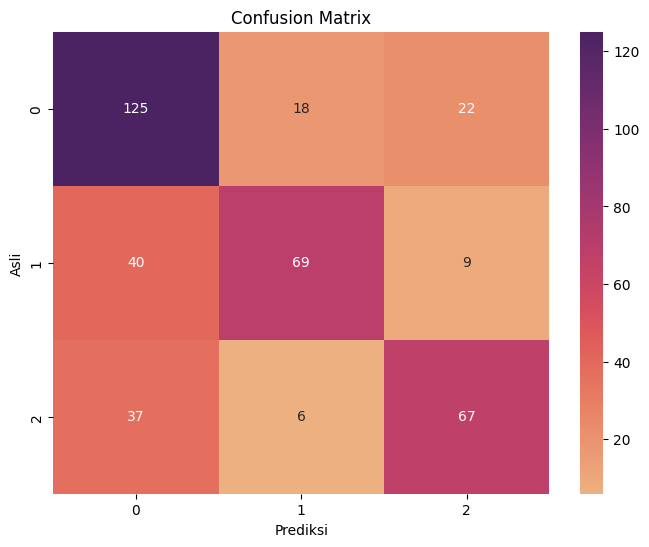

Kelas: Netral
True Positives: 125
False Positives: 77
False Negatives: 40
True Negatives: 151

Kelas: Ras
True Positives: 69
False Positives: 24
False Negatives: 49
True Negatives: 251

Kelas: Agama
True Positives: 67
False Positives: 31
False Negatives: 43
True Negatives: 252



In [1141]:
confusion_matrix = pd.crosstab(y_test, y_pred_test, rownames=['Asli'], colnames=['Prediksi'])
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix, annot=True, cmap='flare', fmt='d')
plt.title("Confusion Matrix")
plt.show()

cm_array = confusion_matrix.values
TP = np.diag(cm_array)
FP = np.sum(cm_array, axis=0) - TP
FN = np.sum(cm_array, axis=1) - TP
TN = np.sum(cm_array) - (TP + FP + FN)

class_names = confusion_matrix.columns
for i, name in enumerate(class_names):
    if name == 0:
        kelas = "Netral"
    elif name == 1:
        kelas = "Ras"
    else:
        kelas = "Agama"
        
    print(f"Kelas: {kelas}")
    print(f"True Positives: {TP[i]}")
    print(f"False Positives: {FP[i]}")
    print(f"False Negatives: {FN[i]}")
    print(f"True Negatives: {TN[i]}\n")

### E.3 Precision

In [1142]:
precision = TP / (TP + FP)
precision = np.mean(precision)
print(f"{precision}")

0.6814736114822805


### E.4 Recall

In [1143]:
recall = TP / (TP + FN)
recall = np.mean(recall)
print(f"{recall}")

0.6504708097928437


### E.5 F-1 Score

In [1144]:
f1 = 2 * (precision * recall) / (precision + recall)
print(f"{f1}")

0.6656113946390708


## F. GUI

### F.1 Tkinter

In [1147]:
import tkinter as tk
from tkinter import *

def predict():
    tweet = Input_Tweet.get("1.0", END).strip()
    clean_tweet = preprocess_text(pd.Series(tweet))
    tf_tweet = calculate_tf(clean_tweet, vocab_index)
    tfidf_tweet = multiply_tf_idf(tf_tweet, vocab_index, idf_values)
    tfidf_tweet = normalize_l2(tfidf_tweet)
    pred = nbm.predict(tfidf_tweet)[0]
    
    Hasil.config(text=f"{pred}")
    
    
# GUI UTAMA 
root = tk.Tk()
root.title("Naive Bayes Multinomial")
root.geometry("500x500")
root.config(bg="#00227e")

Header = Frame(root, bg="#00103b")
Header.pack(fill=X)
Judul = Label(Header, text="Hatespeech Category Prediction", bg="#00103b", fg="#b2c7ff", font=('Arial', 18, 'bold'))
Judul.pack(pady=(10, 5))
Deskripsi = Label(Header, text="NLP + Naive Bayes Multinomial", bg="#00103b", fg="#b2c7ff", font=('Arial', 10, 'bold'))
Deskripsi.pack(pady=(0, 20))

Main = Frame(root, bg="#00227e")
Main.pack(fill=X)
Keterangan = Label(Main, text="Masukkan Tweet", bg="#00227e", fg="#b2c7ff", font=('Arial', 10, 'bold'))
Keterangan.pack(pady=(20, 5))
Input_Tweet = Text(Main, bg='white', fg='black',height=10, width=50)
Input_Tweet.pack()
Button_Tweet = Button(Main, bg="#00103b", fg="#b2c7ff", text="Prediksi", command=predict, width=10, font=('Arial', 12, 'bold'))
Button_Tweet.pack(pady=20)
Hasil = Label(Main, text='-', bg="#00103b", fg="#b2c7ff" ,font=('Arial', 12, 'bold'))
Hasil.pack()

root.mainloop()

In [1146]:
def predict():
    tweet = Input_Tweet.get("1.0", END).strip()
    clean_tweet = preprocess_text(pd.Series(tweet))
    tf_tweet = calculate_tf(clean_tweet, vocab_index)
    tf_idf_tweet = multiply_tf_idf(tf_tweet, vocab_index, idf_values)
    tf_idf_tweet = normalize_l2(tf_idf_tweet)
    pred = nbm.predict(tf_idf_tweet)[0]
    Hasil.config(text=f'{pred}')